## Full dataset (from 2017) for training and testing

- Train, test, cross validation split on all pre-normalised data

## Load files and plot

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
% matplotlib inline

In [2]:
# load normalised datasets
norm_filenames = [f for f in os.listdir() if f.endswith('normalized.csv')]
results_filenames = [f for f in os.listdir() if f.endswith('results.csv')]
raw_filenames = [f for f in os.listdir() if f.endswith('rawdata.csv')]

def load_files_concat(files):
    file_list = []
    for f in files:
        file_list.append(pd.read_csv(f, index_col = None))
    total_df = pd.concat(file_list)
    return total_df


results_df =load_files_concat(results_filenames).drop(['names','Order', 'L'], axis = 1)
raw_df = load_files_concat(raw_filenames).drop(['filecount','Order'], axis = 1)

In [3]:
def load_files_transpose_concat(files):
    file_list = []
    for f in files:
        file_list.append(pd.read_csv(f, index_col = None).set_index(['date','ID']).stack().reset_index())
    total_df = pd.concat(file_list)
    return total_df


norm_df = load_files_transpose_concat(norm_filenames)
norm_df.columns = ['date', 'ID','Wavelength','Intensity']
norm_df = norm_df[norm_df['Wavelength']!= 'Read']
norm_df = norm_df[norm_df['Wavelength']!= 'Unnamed: 0']
norm_df = norm_df[norm_df['Intensity']< 1000]

In [4]:
raw_plotdata = raw_df.drop(['Read','ID'], axis =1).groupby(['date','Wavelength']).agg([np.mean,np.std])
norm_df['Wavelength']= norm_df['Wavelength'].apply(lambda x: math.floor(float(x)))
norm_plotdata = norm_df.drop('ID', axis =1).groupby(['date','Wavelength']).agg([np.mean,np.std])

In [5]:
raw_plotdata.columns = raw_plotdata.columns.droplevel(0)
norm_plotdata.columns =norm_plotdata.columns.droplevel(0)

In [6]:
raw_plotdata = raw_plotdata.reset_index()
norm_plotdata = norm_plotdata.reset_index()

In [7]:
colours = {'Mar17': 'red', 'Apr17':'blue', 'May17': 'green', 'Aug17':'yellow', 'Nov17':'black'}
# map colours onto dataframe
raw_plotdata['Colour']= raw_plotdata['date'].map(colours)
norm_plotdata['Colour']= norm_plotdata['date'].map(colours)

# grouped by colour
raw_grouped = raw_plotdata.groupby('date')
norm_grouped = norm_plotdata.groupby('date')

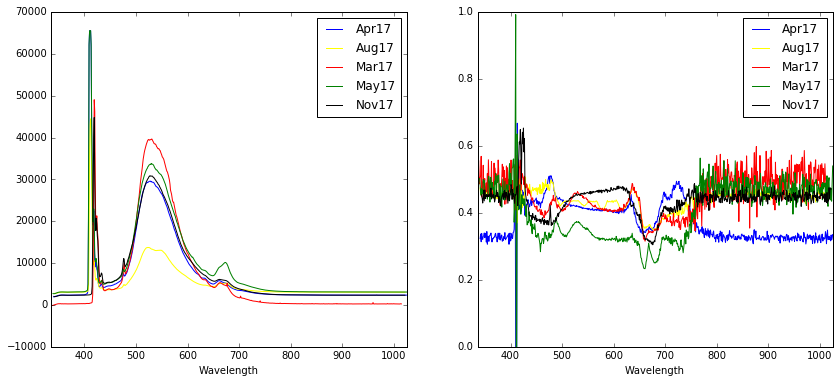

In [8]:
#plot
fig, ax = plt.subplots(1,2, figsize = (14, 6))
for key, value in raw_grouped:
     value.plot(ax = ax[0], x = 'Wavelength', y = 'mean', label = key, color = colours[key])
        
for key, value in norm_grouped:
     value.plot(ax = ax[1], x = 'Wavelength', y = 'mean', label = key, color = colours[key])    

## Train, test, cross validation split

In [9]:
def avg_over_col(df, num_col):
    new_df = pd.DataFrame()
    curr_col = 0
    for i in range(num_col,len(df.columns)+1, num_col):
        working_df = df.iloc[:,curr_col:i]
        colname = str(working_df.columns[0])
        new_df[colname]=working_df.mean(axis = 1)
        curr_col += num_col
    return(new_df)

In [10]:
## make wide df first and truncate data to between 450 and 850 nm
truncated_long =  norm_df[norm_df['Wavelength'].between(450, 850)].groupby(['date','ID','Wavelength']).agg(np.mean)
truncated_wide = truncated_long.unstack()
truncated_wide.columns = truncated_wide.columns.droplevel(0)
truncated_wide = avg_over_col(truncated_wide, 4)
truncated_wide = truncated_wide.reset_index()
full_df_norm = pd.merge(truncated_wide, results_df, on = ['ID','date'], how = 'left').dropna()


In [11]:
X_norm = full_df_norm.iloc[:, 2:-4]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,:1]

In [12]:
# K-fold validation with sklearn
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 25, shuffle = True)
# sample code for training
for train_index, test_index in kf.split(X_norm):
    print('Train:', train_index, 'Test:', test_index)
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,:],Y.iloc[test_index,:]

Train: [  0   2   3   4   5   8  10  11  12  13  14  15  16  17  19  20  22  24
  25  27  28  29  31  32  33  34  36  40  41  42  44  45  46  47  48  50
  52  54  55  56  57  58  59  62  64  65  66  67  68  69  70  72  73  75
  76  78  79  82  83  85  86  87  88  89  90  93  95  98  99 101 102 104
 106 107 108 109 110 115 116 117 122 124 127 129 130 131 132 136 137 139
 141 143 145 146 147 148 149 151 154 155 156 158 159 160 164 165 167 168
 170 171 173 174 175 176 177 178 180 181 182 184 185 188 191 193 197 198
 199 200 201 202 203 204 206 208 210 212 213 214 216 217 220 222 223 225
 226 227 228 229 230 232 235 238 239 240 244 245 247 248 249 250 251 252
 253 255 257 258 259 260 261 263 265 267 269 272 274 275 277 281 282 283
 284 285 286 287 289 290 291 293 294 295 297 300 303 304 306 308 309 310
 312 313 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 337 338 339 340 341 342 348 349 350 351 352 353 354 355 356
 359 361 362 364 368 369 371 372 374 375 376

## Artificial neural nets for regression

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [14]:
Y.head()

,C,F,M,P
0,22.0,2.96,16.7,3.71
1,84.0,4.73,24.4,3.97
2,28.0,4.15,18.6,3.73
3,265.0,3.47,44.5,2.99
4,13.0,4.49,31.0,3.47


mean squared error: 0.0883135296404 Mean Absolute Error: 0.238076491356 R-squared: 0.303755322091
mean squared error: 0.133857177695 Mean Absolute Error: 0.306183278561 R-squared: -0.0950576430081
mean squared error: 0.103546714783 Mean Absolute Error: 0.251804443399 R-squared: 0.113170767037


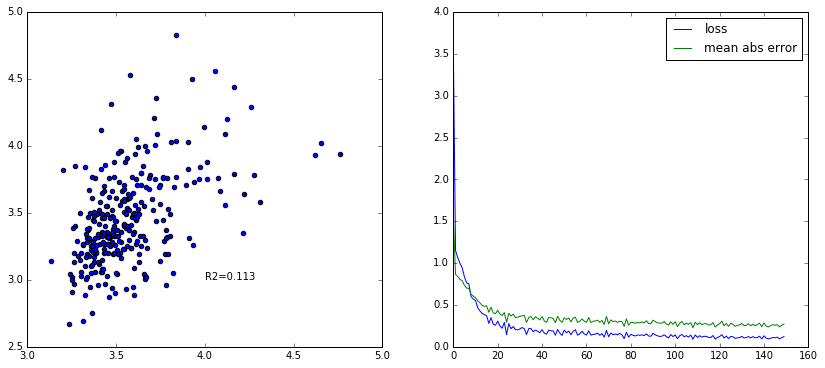

In [16]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser

for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.31700889349 Mean Absolute Error: 0.248189494809 R-squared: 0.242029356172
mean squared error: 2.83527099927 Mean Absolute Error: 1.64549363295 R-squared: -22.1507140019
mean squared error: 0.300259336233 Mean Absolute Error: 0.256463860075 R-squared: 0.10780546574


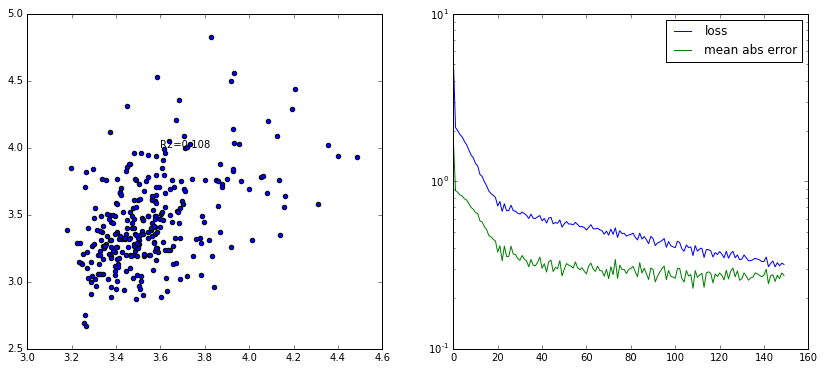

In [17]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(10, activation = 'relu', kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(3.6,4,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

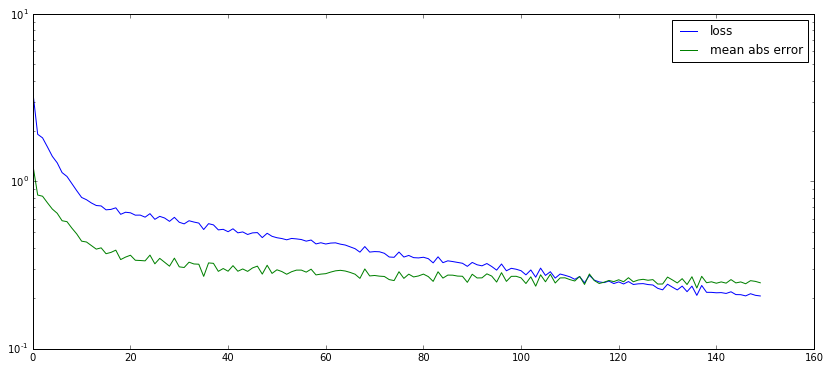

In [15]:
## save model Relu_lasso
## requires h5py (pip available)
import h5py
w_reg = kr.l1(0.001)

# model initiation
model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
model.add(Dense(10, activation = 'relu', kernel_regularizer = w_reg))
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= model.fit(X_norm, Y['P'], epochs=150, batch_size=50, verbose =0)
model.save('relu_L1.h5')

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax.legend()
ax.set_yscale('log')

mean squared error: 0.0947414721797 Mean Absolute Error: 0.240091635287 R-squared: 0.253078815466
mean squared error: 0.089604703337 Mean Absolute Error: 0.228955989679 R-squared: 0.266962647416
mean squared error: 0.0916608526309 Mean Absolute Error: 0.229210855166 R-squared: 0.214967631005


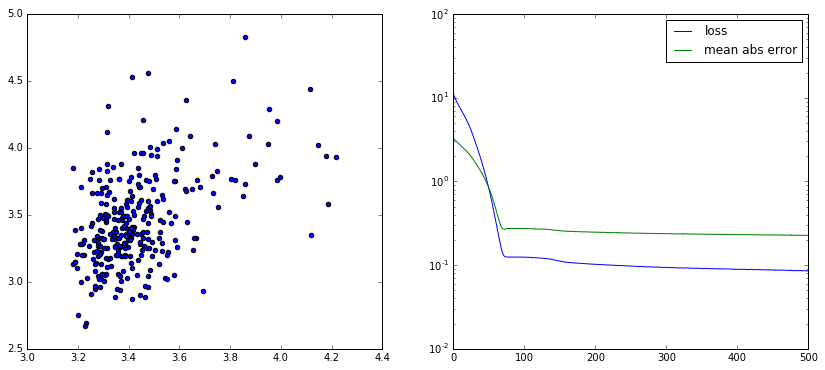

In [16]:
## sigmoid activation function 
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

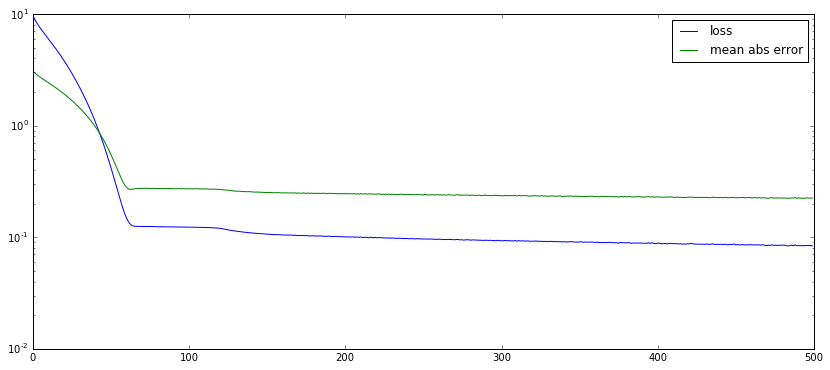

In [17]:
# save model sigmoid
model = Sequential()
model.add(Dense(5, input_dim=100, activation='sigmoid'))
model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
model.save('sigmoid.h5')

# plot
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax.legend()
ax.set_yscale('log')

mean squared error: 0.114359861513 Mean Absolute Error: 0.257092852592 R-squared: 0.163685894277
mean squared error: 0.111806325614 Mean Absolute Error: 0.243239576618 R-squared: 0.159707288542
mean squared error: 0.119150759081 Mean Absolute Error: 0.266115470827 R-squared: 0.0167845672026


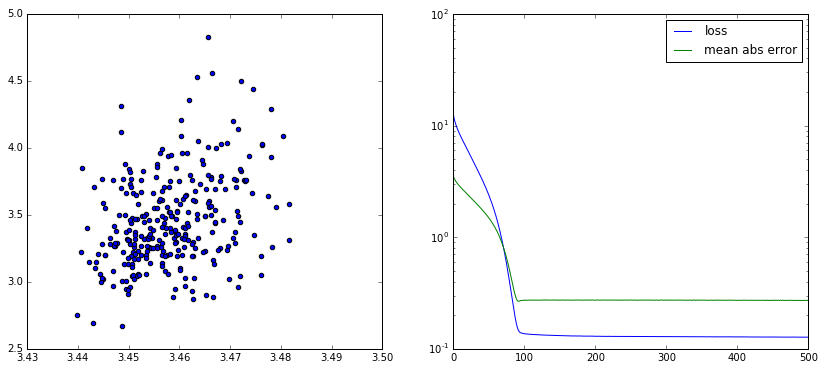

In [19]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 2.5002816116717638e-05 
R2: 0.4393048000170673


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 2.4789411538634614e-05 
R2: 0.35364900407824096
chosen alpha: 2.6726318145307443e-05 
R2: 0.39235428123737537
r2: 0.39235428123737537


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


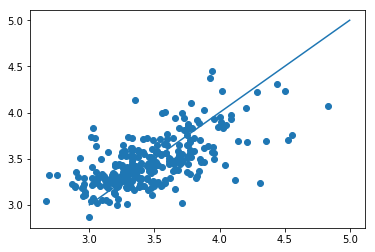

In [21]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model= LassoCV(cv=20)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


### Support vector regression

Max r2: 0.4746047111263935 
Epsilon: 0.08333333333333333
Max r2: 0.3708274247022755 
Epsilon: 0.08333333333333333
Max r2: 0.40465005757803185 
Epsilon: 0.03125


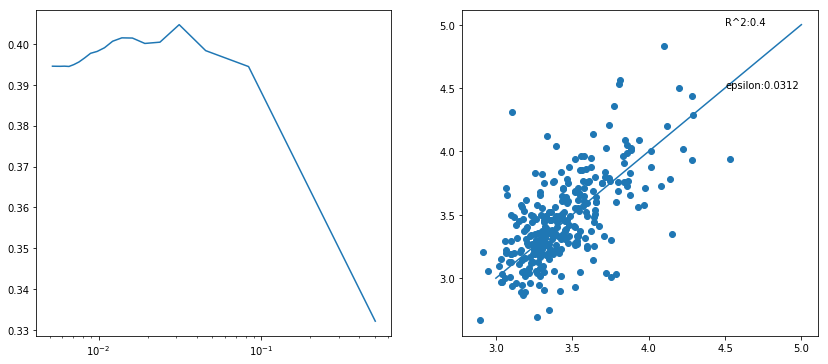

In [31]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 85, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.46134228079392653 
C: 83.33333333333333
Max r2: 0.3993011263455486 
C: 6.578947368421052
Max r2: 0.40429983060912034 
C: 83.33333333333333


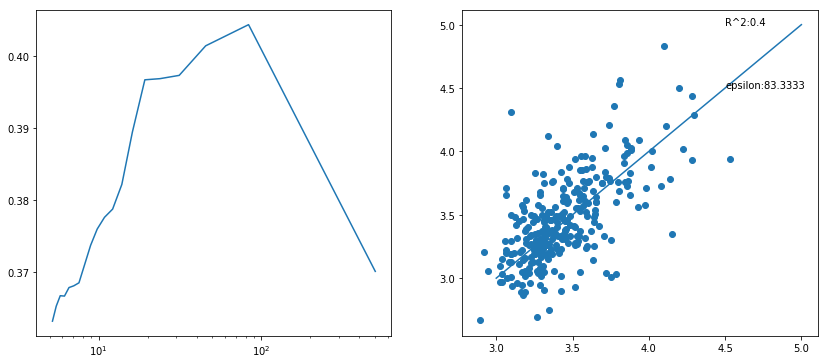

In [30]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 500/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.03, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.24408021548479023 
C: 5
Max r2: 0.3020416445256552 
C: 5
Max r2: 0.21371489606443028 
C: 9


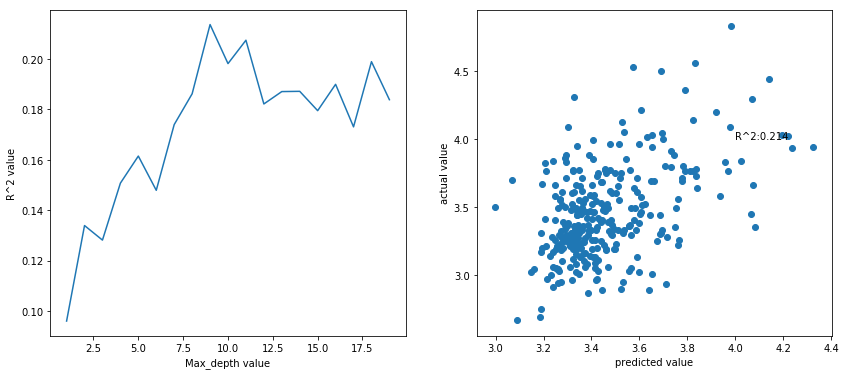

In [34]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train, y_train)
        predictions.append(np.array(rf.predict(X_test)))
        rf_scores.append(rf.score(X_test, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

## Exclude August dataset
- I think the August dataset is vastly different from the rest, try excluding
- Train, test, cross validation split on 4/5 pre-normalised datasets

## Train, test, cross validation split

In [35]:
def avg_over_col(df, num_col):
    new_df = pd.DataFrame()
    curr_col = 0
    for i in range(num_col,len(df.columns)+1, num_col):
        working_df = df.iloc[:,curr_col:i]
        colname = str(working_df.columns[0])
        new_df[colname]=working_df.mean(axis = 1)
        curr_col += num_col
    return(new_df)

In [36]:
## make wide df first and truncate data to between 450 and 850 nm
truncated_long =  norm_df[norm_df['Wavelength'].between(450, 850)].groupby(['date','ID','Wavelength']).agg(np.mean)
truncated_wide = truncated_long.unstack()
truncated_wide.columns = truncated_wide.columns.droplevel(0)
truncated_wide = avg_over_col(truncated_wide, 4)
truncated_wide = truncated_wide.reset_index()
full_df_norm = pd.merge(truncated_wide, results_df, on = ['ID','date'], how = 'left').dropna()
full_df_norm = full_df_norm[full_df_norm['date'] != 'Aug17']


In [37]:
X_norm = full_df_norm.iloc[:, 2:-4]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,:1]

In [38]:
# K-fold validation with sklearn
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 25, shuffle = True)
# sample code for training
for train_index, test_index in kf.split(X_norm):
    print('Train:', train_index, 'Test:', test_index)
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,:],Y.iloc[test_index,:]

Train: [  0   2   3   5   8  10  11  12  13  14  15  16  17  18  20  22  24  25
  27  28  29  31  32  34  35  36  40  41  42  43  44  45  46  48  50  52
  54  55  56  57  58  59  62  64  65  66  67  68  69  70  72  73  74  75
  76  78  79  80  82  83  85  86  87  88  89  90  93  95  98  99 101 102
 104 106 107 108 109 110 116 117 122 124 126 127 129 130 131 132 136 137
 139 141 143 145 146 147 148 151 154 155 156 158 160 164 165 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 184 185 186 188 191
 193 195 197 198 199 200 201 202 203 204 206 208 209 212 213 214 216 217
 220 222 223 225 227 228 229 230 232 233 235 238 239 240 243 244 245 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 263 265 267 268
 269 272 273 274 275 277 280 281 282 284 285 286 287 289 290 291 292 293
 294 295 297 300 301 303 304 305 306 307 308 309 310 312 313 314 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 332 333 334 335 339 340
 341 342 346 348 349 350 351 352 353 354 355

## Artificial neural nets for regression

In [39]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [40]:
Y.head()

,C,F,M,P
0,22.0,2.96,16.7,3.71
1,84.0,4.73,24.4,3.97
2,28.0,4.15,18.6,3.73
3,265.0,3.47,44.5,2.99
4,13.0,4.49,31.0,3.47


mean squared error: 0.2622943596234397 Mean Absolute Error: 0.4414712635297624 R-squared: -1.5585063127923977
mean squared error: 0.1132801685423132 Mean Absolute Error: 0.2535190542065908 R-squared: 0.09314181011922129
mean squared error: 0.18377533223893908 Mean Absolute Error: 0.3619182753184485 R-squared: -0.2654409485671996


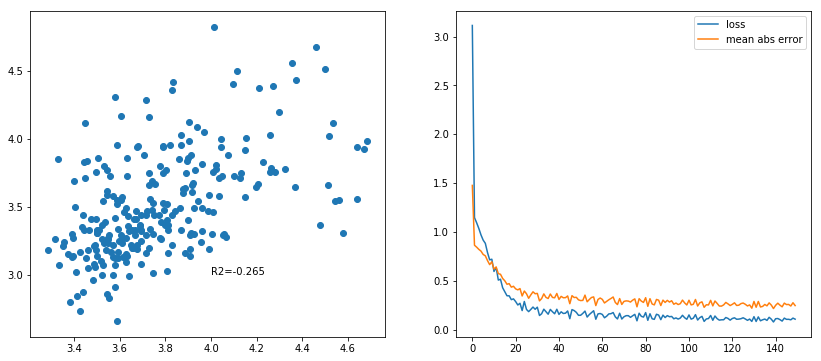

In [41]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser

for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.37131809289493256 Mean Absolute Error: 0.28918672128329204 R-squared: -0.19421286081673172
mean squared error: 0.42648030320803326 Mean Absolute Error: 0.37585341835778857 R-squared: -0.6101394329354228
mean squared error: 0.7051591248739333 Mean Absolute Error: 0.5694380620169261 R-squared: -2.0600004649238763


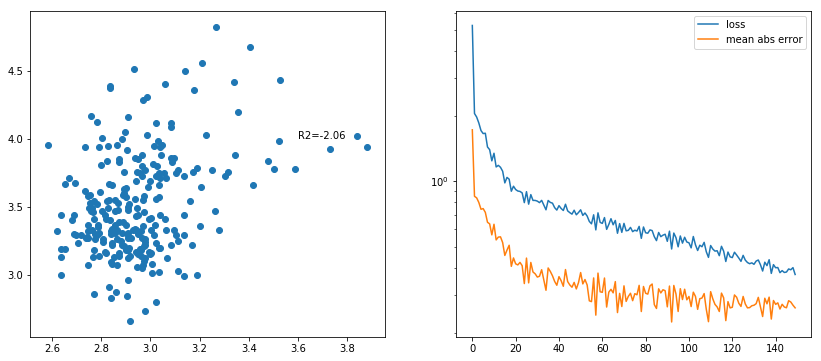

In [42]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(10, activation = 'relu', kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0)
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(3.6,4,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.06951172159068168 Mean Absolute Error: 0.20793567455950238 R-squared: 0.32195963728258314
mean squared error: 0.09277059962706906 Mean Absolute Error: 0.23501203906914545 R-squared: 0.2573300669985762
mean squared error: 0.1013400409784582 Mean Absolute Error: 0.25034897218620966 R-squared: 0.3021923227096752


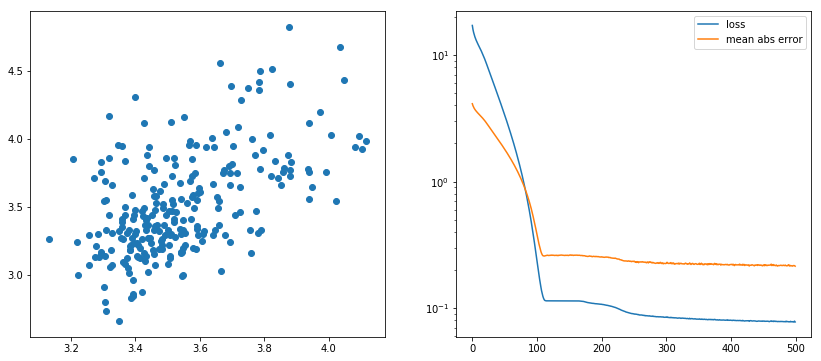

In [43]:
## sigmoid activation function
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.08640169476469357 Mean Absolute Error: 0.21303558184040916 R-squared: 0.2761167686951529
mean squared error: 0.11318328101483602 Mean Absolute Error: 0.25043204545028624 R-squared: 0.19917822607367086
mean squared error: 0.1333257035012283 Mean Absolute Error: 0.25777383763638756 R-squared: 0.1919617320532937


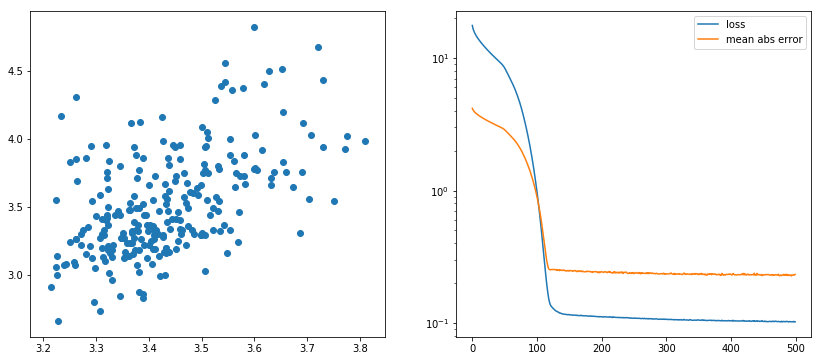

In [44]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.00013840945856866374 
R2: 0.4550577631871008


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 5.246524933310937e-05 
R2: 0.3986027118118932
chosen alpha: 6.895155413612731e-05 
R2: 0.40112533875257206
r2: 0.40112533875257206


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


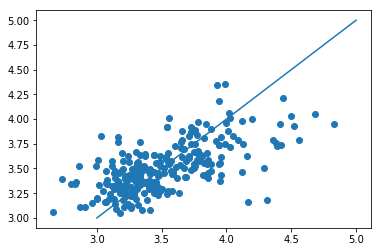

In [45]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]# for 'P' dependent var
    
    model= LassoCV(cv=20)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


### Support vector regression

Max r2: 0.44179384743536826 
Epsilon: 0.08333333333333333
Max r2: 0.4050742910054106 
Epsilon: 0.023809523809523808
Max r2: 0.3799636452898171 
Epsilon: 0.08333333333333333


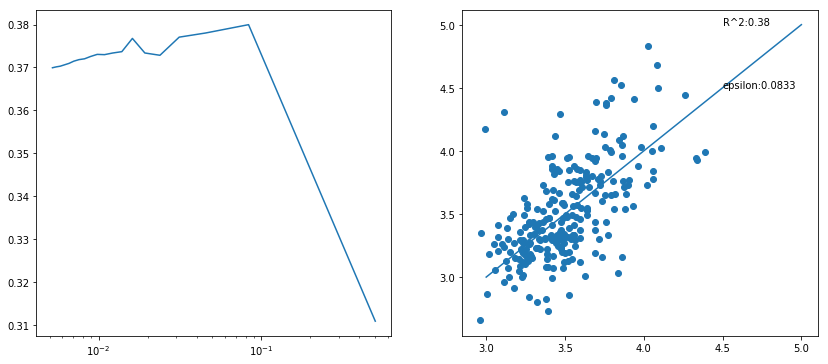

In [47]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 85, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.4586444488524718 
C: 31.25
Max r2: 0.425223008533125 
C: 10.869565217391305
Max r2: 0.39703687137598276 
C: 10.869565217391305


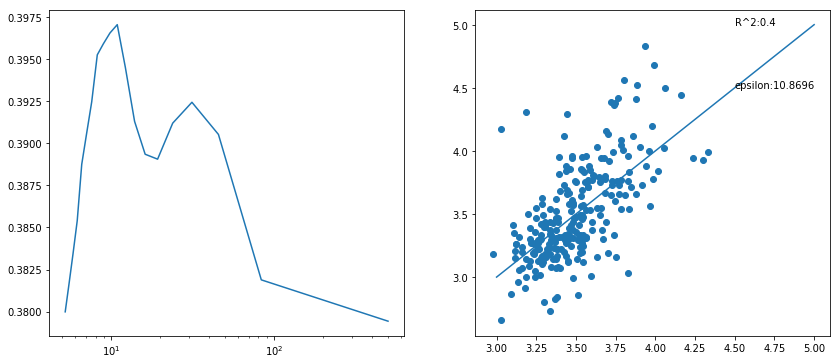

In [49]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 500/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.1, kernel = 'linear')
        clf.fit(X_train, y_train)
        svr_prediction.append(clf.predict(X_test))
        svr_r2.append(clf.score(X_test,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.3247796903281298 
C: 7
Max r2: 0.23432502920096476 
C: 5
Max r2: 0.32665731417348676 
C: 4


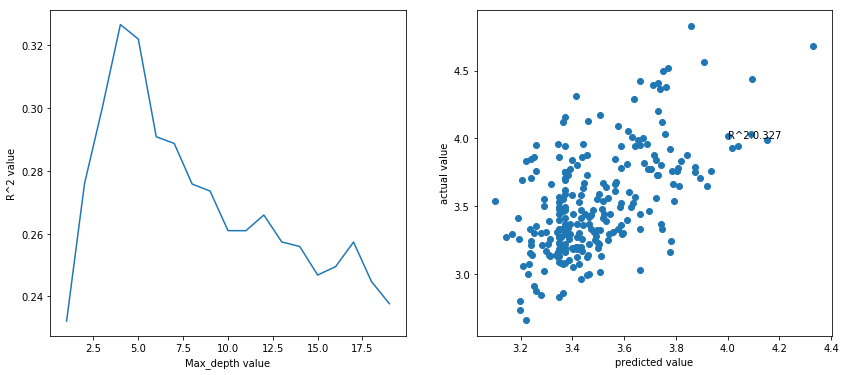

In [50]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
    # split
    X_train, X_test = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1] # for 'P' dependent 
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train, y_train)
        predictions.append(np.array(rf.predict(X_test)))
        rf_scores.append(rf.score(X_test, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

## Full dataset (non-normalised) 

- perform normalisation on full dataset after concatanation

In [18]:
raw_avg = raw_df[raw_df['Wavelength'].between(450,850)].drop('Read',axis = 1).groupby(['date','ID','Wavelength']).agg(np.mean) # still requires averaging across replicates, truncating, normalising
raw_wide = raw_avg.unstack()
raw_wide.columns = raw_wide.columns.droplevel(0)
raw_wide = raw_wide.reset_index().dropna(axis = 1)

In [117]:
# normalise (min max scaling)
from sklearn.preprocessing import MinMaxScaler
norm_scale = MinMaxScaler()
norm_df = avg_over_col(pd.DataFrame(norm_scale.fit_transform(raw_wide.iloc[:, 2:]), columns = raw_wide.iloc[:, 2:].columns),4).join(raw_wide.iloc[:, :2])


# standardize (z-score)
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()
std_df = avg_over_col(pd.DataFrame(std_scale.fit_transform(raw_wide.iloc[:, 2:]), columns = raw_wide.iloc[:, 2:].columns),4).join(raw_wide.iloc[:, :2])

# saving scalers
from sklearn.externals import joblib
joblib.dump(norm_scale, 'normalizer.save')
joblib.dump(std_scale, 'standarizer.save')


['standarizer.save']

### Train test splits

In [90]:
## make wide df first and truncate data to between 450 and 850 nm
full_df_norm = pd.merge(norm_df, results_df, on = ['ID','date'], how = 'left').dropna()
full_df_std = pd.merge(std_df, results_df, on = ['ID','date'], how = 'left').dropna()


In [91]:
X_norm = full_df_norm.iloc[:, :-6]
X_std = full_df_std.iloc[:, :-6]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,-5]

In [92]:
# K-fold validation with sklearn
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3, random_state = 25, shuffle = True)
# sample code for training
for train_index, test_index in kf.split(X_norm):
    print('Train:', train_index, 'Test:', test_index)
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_s, X_test_s = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,:],Y.iloc[test_index,:]

Train: [  0   2   3   4   5   8  10  11  12  13  14  15  16  17  19  20  22  24
  25  27  28  29  31  32  33  34  36  40  41  42  44  45  46  47  48  50
  52  54  55  56  57  58  59  62  64  65  66  67  68  69  70  72  73  75
  76  78  79  82  83  85  86  87  88  89  90  93  95  98  99 101 102 104
 106 107 108 109 110 115 116 117 122 124 127 129 130 131 132 136 137 139
 141 143 145 146 147 148 149 151 154 155 156 158 159 160 164 165 167 168
 170 171 173 174 175 176 177 178 180 181 182 184 185 188 191 193 197 198
 199 200 201 202 203 204 206 208 210 212 213 214 216 217 220 222 223 225
 226 227 228 229 230 232 235 238 239 240 244 245 247 248 249 250 251 252
 253 255 257 258 259 260 261 263 265 267 269 272 274 275 277 281 282 283
 284 285 286 287 289 290 291 293 294 295 297 300 303 304 306 308 309 310
 312 313 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 337 338 339 340 341 342 348 349 350 351 352 353 354 355 356
 359 361 362 364 368 369 371 372 374 375 376

## Artificial neural nets for regression

In [93]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

mean squared error: 0.0899305814629 Mean Absolute Error: 0.228378479481 R-squared: 0.291006817902
mean squared error: 0.0837216614683 Mean Absolute Error: 0.226813520789 R-squared: 0.315090558041
mean squared error: 0.0785937298834 Mean Absolute Error: 0.217013918559 R-squared: 0.326881435067


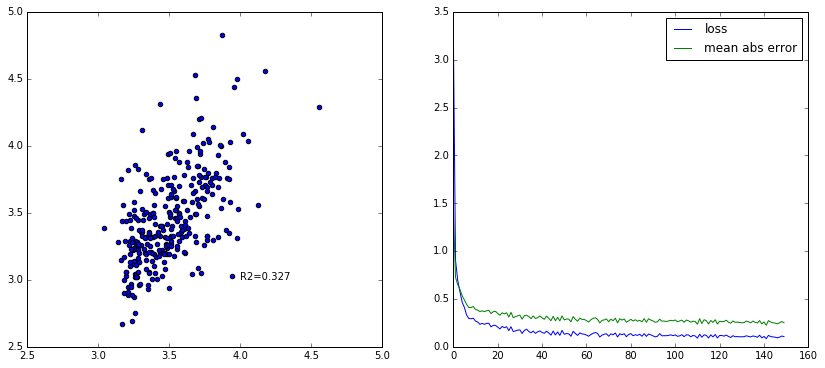

In [94]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser
## Normalised


for train_index, test_index in kf.split(X_norm):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_s, X_test_s = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.0832564464708 Mean Absolute Error: 0.229218298594 R-squared: 0.343624264707
mean squared error: 0.0805079996089 Mean Absolute Error: 0.218690908551 R-squared: 0.341380859442
mean squared error: 0.0874189820141 Mean Absolute Error: 0.221008635362 R-squared: 0.251297280101


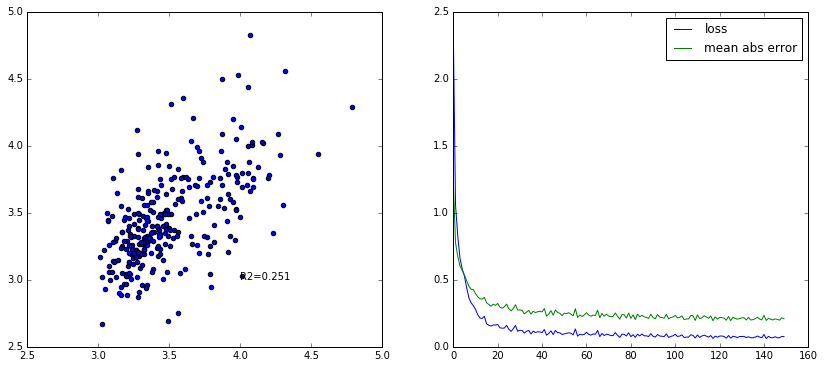

In [101]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser
## Normalised


for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.261630525788 Mean Absolute Error: 0.233399984737 R-squared: 0.272034818986
mean squared error: 0.223796926141 Mean Absolute Error: 0.227860594591 R-squared: 0.298372029126
mean squared error: 0.219923290014 Mean Absolute Error: 0.214254573981 R-squared: 0.317523481142


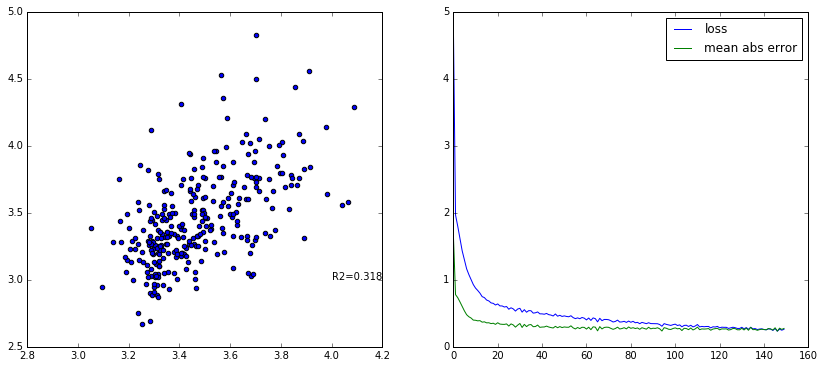

In [96]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_s, X_test_s = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(20, activation = 'relu',kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.209522369504 Mean Absolute Error: 0.228606417378 R-squared: 0.32694595192
mean squared error: 0.24684103171 Mean Absolute Error: 0.229238854249 R-squared: 0.244264127411
mean squared error: 0.240716651281 Mean Absolute Error: 0.235144358575 R-squared: 0.216162651425


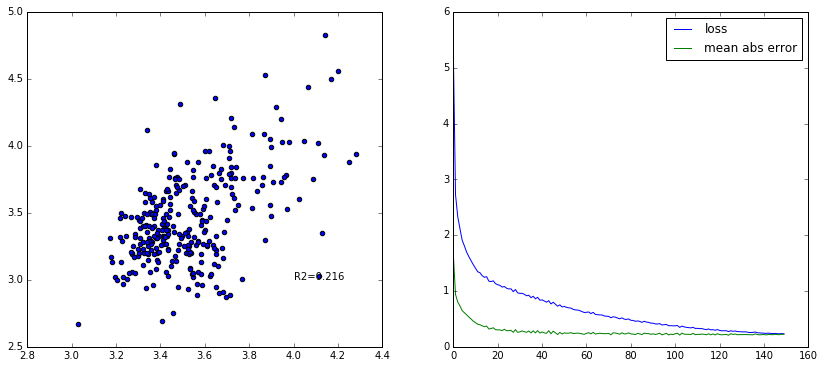

In [100]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(30, activation = 'relu',kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.0908818000307 Mean Absolute Error: 0.237661625445 R-squared: 0.283507625707
mean squared error: 0.0876943555474 Mean Absolute Error: 0.229729385376 R-squared: 0.282590780746
mean squared error: 0.079164816613 Mean Absolute Error: 0.207640239497 R-squared: 0.321990347233


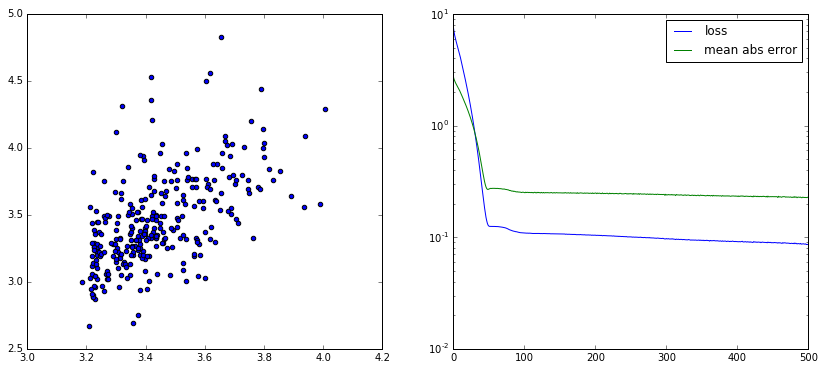

In [110]:
## sigmoid activation function
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

In [107]:
Y.head()

,C,F,M,P
0,22.0,2.96,16.7,3.71
1,84.0,4.73,24.4,3.97
2,28.0,4.15,18.6,3.73
3,265.0,3.47,44.5,2.99
4,13.0,4.49,31.0,3.47


In [112]:
# save sigmoid 1
model = Sequential()
model.add(Dense(5, input_dim=100, activation='sigmoid'))
model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_norm, Y['P'], epochs=500, batch_size=50, verbose =0))
model.save('sigmoid_norm.h5')

history= (model.fit(X_std, Y['P'], epochs=500, batch_size=50, verbose =0))
model.save('sigmoid_std.h5')


mean squared error: 0.0656582507491 Mean Absolute Error: 0.198081099888 R-squared: 0.482364621932
mean squared error: 0.0701992894709 Mean Absolute Error: 0.205388856729 R-squared: 0.425714281573
mean squared error: 0.0649313628674 Mean Absolute Error: 0.193887879948 R-squared: 0.443893198385


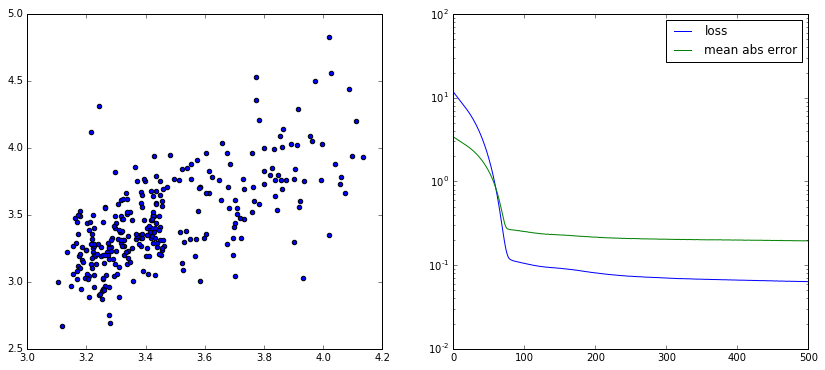

In [103]:
## sigmoid activation function
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

In [113]:
#save model

model = Sequential()
model.add(Dense(5, input_dim=100, activation='sigmoid'))
model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_norm, Y['P'], epochs=500, batch_size=50, verbose =0))
model.save('sigmoid_L1_norm.h5')

history= (model.fit(X_std, Y['P'], epochs=500, batch_size=50, verbose =0))
model.save('sigmoid_L1_std.h5')

mean squared error: 0.119027699729 Mean Absolute Error: 0.251481300195 R-squared: 0.122513220389
mean squared error: 0.116150587002 Mean Absolute Error: 0.24916813453 R-squared: 0.12408737528
mean squared error: 0.109204887897 Mean Absolute Error: 0.239070759416 R-squared: 0.134569904427


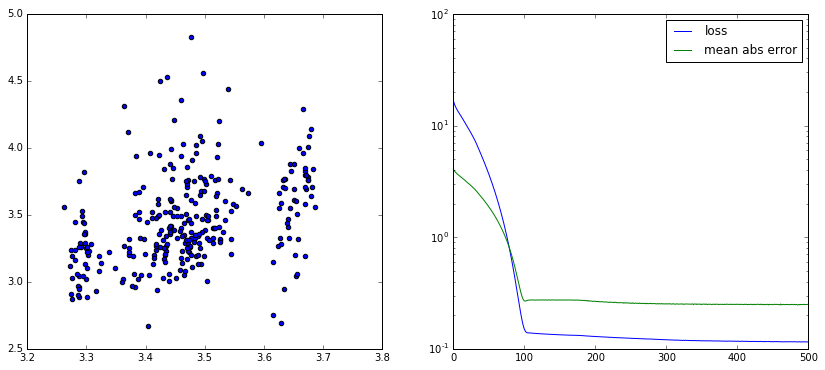

In [104]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)

for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.10062994654 Mean Absolute Error: 0.229058525662 R-squared: 0.314687173102
mean squared error: 0.0961985640725 Mean Absolute Error: 0.221651835442 R-squared: 0.314053491784
mean squared error: 0.0853414505223 Mean Absolute Error: 0.204670680364 R-squared: 0.354699650235


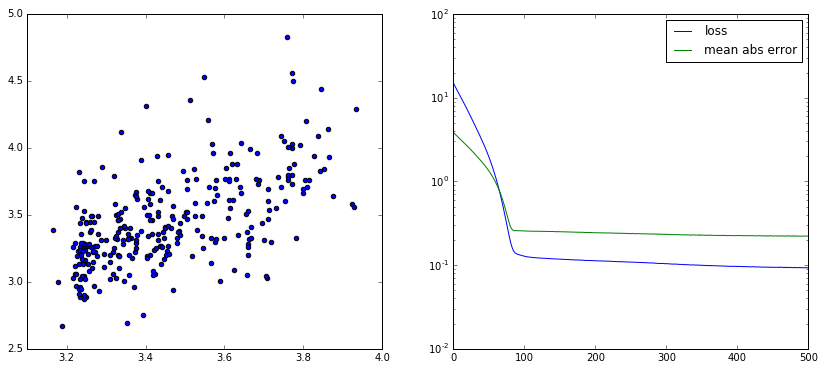

In [105]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)

#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 3.649527391894517e-05 
R2: 0.44564525782036357


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 2.7599432316473518e-05 
R2: 0.36377709891893306
chosen alpha: 4.080773478153111e-05 
R2: 0.4412450645924717
r2: 0.4412450645924717


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


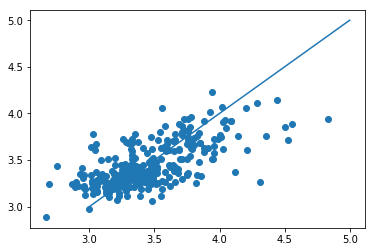

In [141]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model= LassoCV(cv=20)
    model.fit(X_train_n, y_train)
    y_predict = model.predict(X_test_n)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.0001812353752130371 
R2: 0.4463153886737984


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.00015059525265015108 
R2: 0.3644369827017757
chosen alpha: 0.00020356110757954453 
R2: 0.4417520371892051
r2: 0.4417520371892051


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


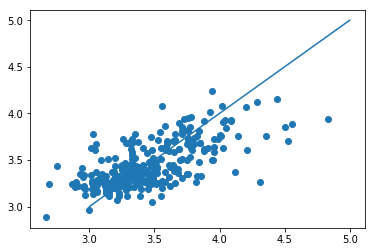

In [142]:
from sklearn.linear_model import LassoCV
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model= LassoCV(cv=20)
    model.fit(X_train_n, y_train)
    y_predict = model.predict(X_test_n)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))

### Support vector regression

Max r2: 0.4507103765973863 
Epsilon: 0.08333333333333333
Max r2: 0.38970310227440363 
Epsilon: 0.016129032258064516
Max r2: 0.44232814890172056 
Epsilon: 0.08333333333333333


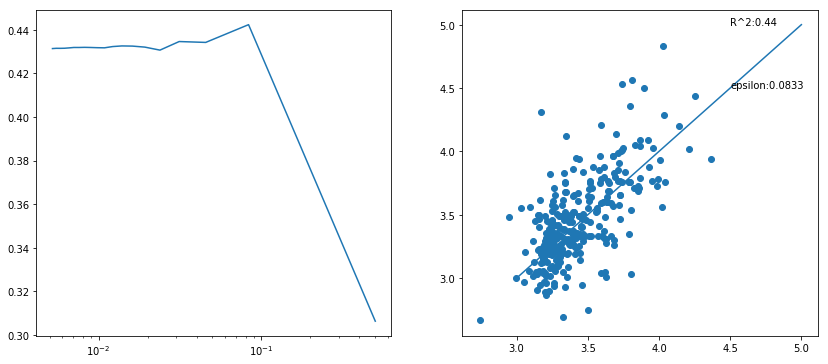

In [143]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 85, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.4555605811627211 
C: 100.0
Max r2: 0.3858216157843659 
C: 16.666666666666668
Max r2: 0.44446589252755064 
C: 100.0


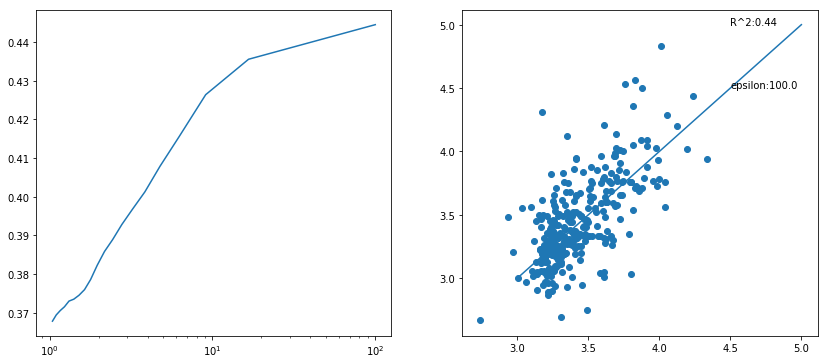

In [145]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR

for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 100/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.1, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.4600737805161961 
Epsilon: 0.08333333333333333
Max r2: 0.3865500931890904 
Epsilon: 0.045454545454545456
Max r2: 0.4438135763387052 
Epsilon: 0.08333333333333333


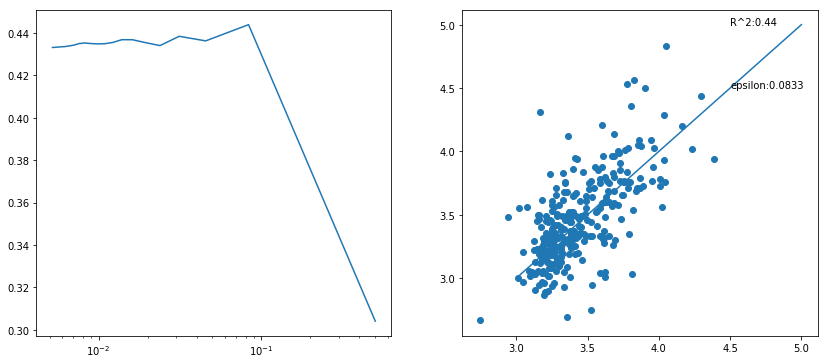

In [146]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 5, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.4589045024354314 
C: 3.3333333333333335
Max r2: 0.39550119759405344 
C: 0.6451612903225806
Max r2: 0.4466186903510153 
C: 3.3333333333333335


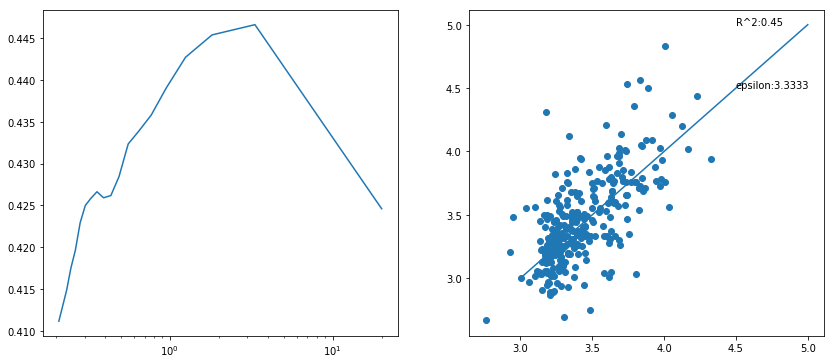

In [147]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR

#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 20/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.1, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.3469391655254298 
C: 12
Max r2: 0.30543708341872455 
C: 12
Max r2: 0.36821282565209035 
C: 8


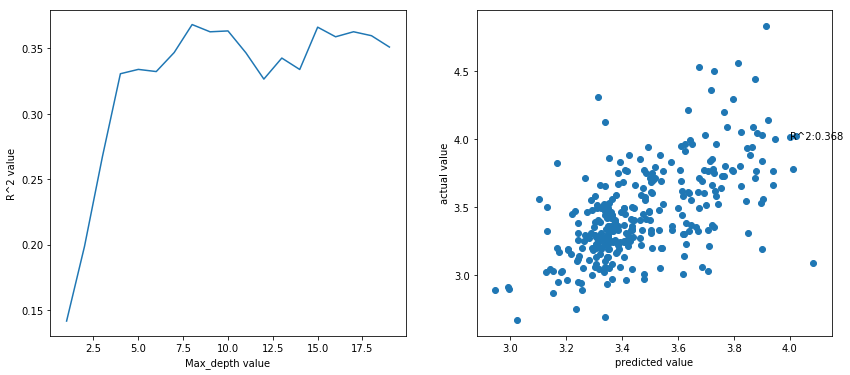

In [149]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train_n, y_train)
        predictions.append(np.array(rf.predict(X_test_n)))
        rf_scores.append(rf.score(X_test_n, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

Max r2: 0.36092957833202677 
C: 12
Max r2: 0.307325870149905 
C: 12
Max r2: 0.36962492223239674 
C: 17


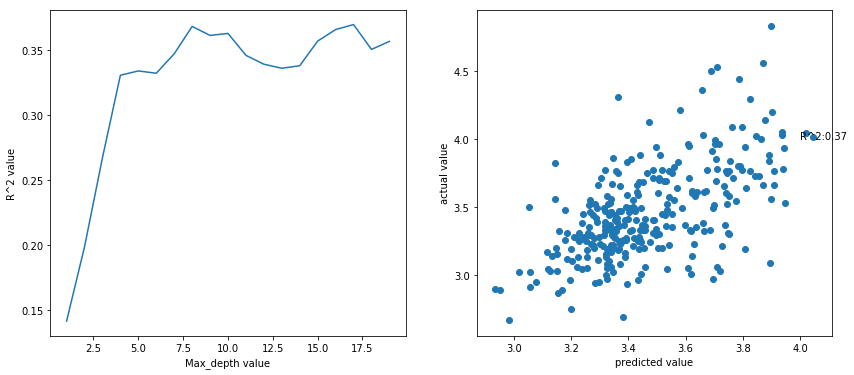

In [150]:
from sklearn.ensemble import RandomForestRegressor
    
    
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train_n, y_train)
        predictions.append(np.array(rf.predict(X_test_n)))
        rf_scores.append(rf.score(X_test_n, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

## Exclude August dataset (non-normalised)

In [158]:
raw_avg = raw_df[raw_df['Wavelength'].between(450,850)].drop('Read',axis = 1).groupby(['date','ID','Wavelength']).agg(np.mean) # still requires averaging across replicates, truncating, normalising
raw_wide = raw_avg.unstack()
raw_wide.columns = raw_wide.columns.droplevel(0)
raw_wide = raw_wide.reset_index().dropna(axis = 1)
raw_wide = raw_wide[raw_wide['date'] != 'Nov17']

In [159]:
# normalise (min max scaling)
from sklearn.preprocessing import MinMaxScaler
norm_scale = MinMaxScaler()
norm_df = avg_over_col(pd.DataFrame(norm_scale.fit_transform(raw_wide.iloc[:, 2:]), columns = raw_wide.iloc[:, 2:].columns),4).join(raw_wide.iloc[:, :2])

# standardize (z-score)
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()
std_df = avg_over_col(pd.DataFrame(std_scale.fit_transform(raw_wide.iloc[:, 2:]), columns = raw_wide.iloc[:, 2:].columns),4).join(raw_wide.iloc[:, :2])

In [160]:
## make wide df first and truncate data to between 450 and 850 nm
full_df_norm = pd.merge(norm_df, results_df, on = ['ID','date'], how = 'left').dropna()
full_df_std = pd.merge(std_df, results_df, on = ['ID','date'], how = 'left').dropna()



In [161]:
X_norm = full_df_norm.iloc[:, :-6]
X_std = full_df_std.iloc[:, :-6]
Y = full_df_norm.iloc[:, -4:]
ID = full_df_norm.iloc[:,-5]

## Artificial neural nets for regression

In [162]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

mean squared error: 0.07738858888160835 Mean Absolute Error: 0.22798755620289773 R-squared: 0.4994972576378415
mean squared error: 0.11749991955398356 Mean Absolute Error: 0.25666626347500143 R-squared: 0.35409601733259966
mean squared error: 0.08805236024100606 Mean Absolute Error: 0.22376436751063278 R-squared: 0.35729817566347966


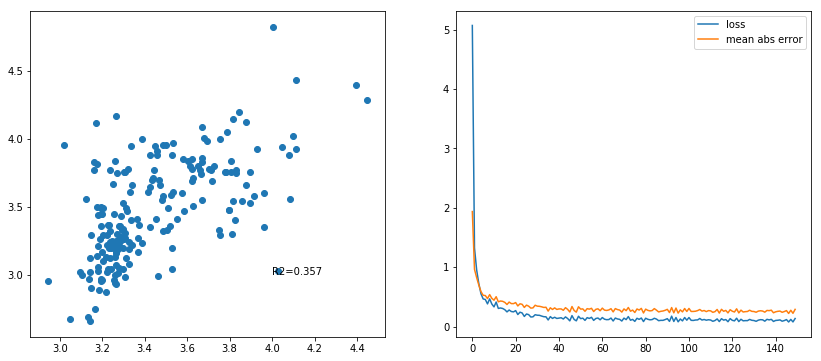

In [163]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser
## Normalised


for train_index, test_index in kf.split(X_norm):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_s, X_test_s = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.13526728322494377 Mean Absolute Error: 0.27853141088508865 R-squared: 0.12517277613949773
mean squared error: 0.154057475837689 Mean Absolute Error: 0.30038837553227987 R-squared: 0.15313696051740444
mean squared error: 0.12444862047346626 Mean Absolute Error: 0.27389283209312254 R-squared: 0.09163871646688038


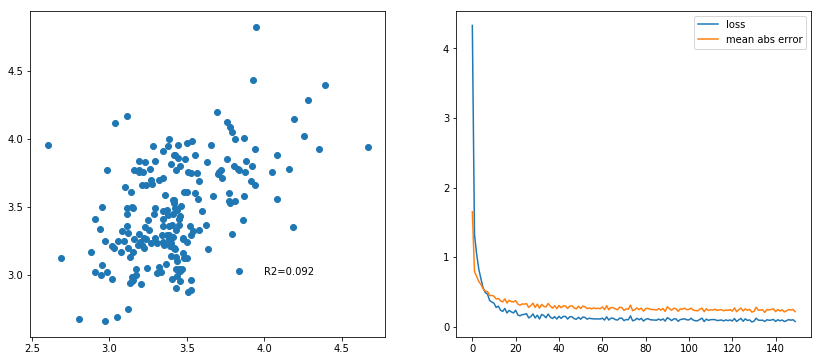

In [164]:
# regular ANN with 'relu' activation function, 'rmsprop' optimiser
## Normalised


for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.32496887763727056 Mean Absolute Error: 0.2482970750447616 R-squared: 0.3976441354797442
mean squared error: 0.32297280806939577 Mean Absolute Error: 0.24220379883224524 R-squared: 0.4350788133164112
mean squared error: 0.35217753125400075 Mean Absolute Error: 0.24609697810033473 R-squared: 0.30508874412593046


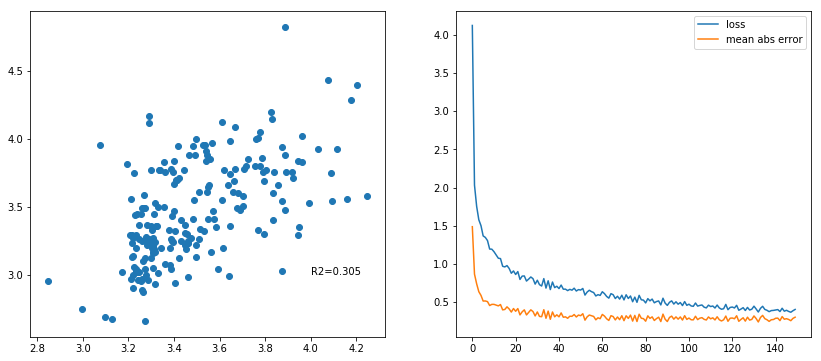

In [165]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_norm):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_s, X_test_s = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(20, activation = 'relu',kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.40892390342592033 Mean Absolute Error: 0.31908868802982626 R-squared: -0.06548956177624055
mean squared error: 0.39417722589761306 Mean Absolute Error: 0.309958675822008 R-squared: 0.16648747646093898
mean squared error: 0.32772879804052957 Mean Absolute Error: 0.26367194216425827 R-squared: 0.17641071900009864


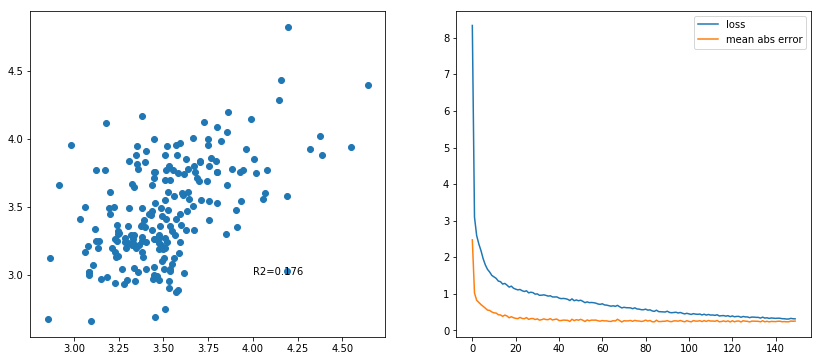

In [166]:
# With Lasso L1 regularization
w_reg = kr.l1(0.001)


for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    # model initiation
    model = Sequential()
    model.add(Dense(100, input_dim=100, activation='relu', kernel_regularizer = w_reg))
    model.add(Dense(20, activation = 'relu',kernel_regularizer = w_reg))
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= model.fit(X_train_n, y_train, epochs=150, batch_size=50, verbose =0)

    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )
    
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.0849119698972378 Mean Absolute Error: 0.2395698124343909 R-squared: 0.45084055940944034
mean squared error: 0.10463517770460508 Mean Absolute Error: 0.25177682473242863 R-squared: 0.42481426386930543
mean squared error: 0.08433731343688035 Mean Absolute Error: 0.23502408498670996 R-squared: 0.3844146233028478


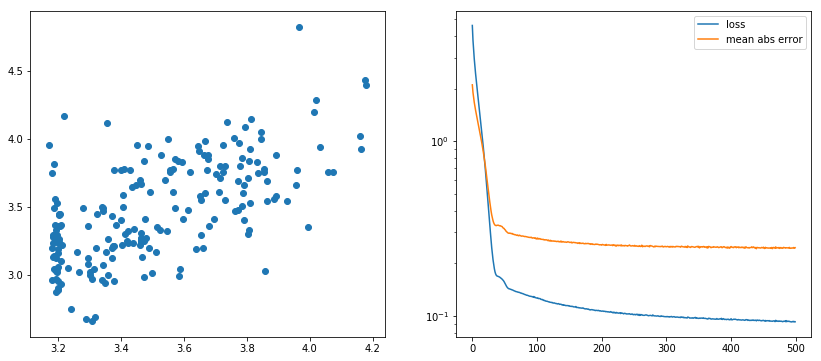

In [167]:
## sigmoid activation function
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.08679630462695094 Mean Absolute Error: 0.23767381964377987 R-squared: 0.43865380701390944
mean squared error: 0.10132593227532304 Mean Absolute Error: 0.24621612513528288 R-squared: 0.44300537366899195
mean squared error: 0.08602190893597719 Mean Absolute Error: 0.23025761508360143 R-squared: 0.37211860204491143


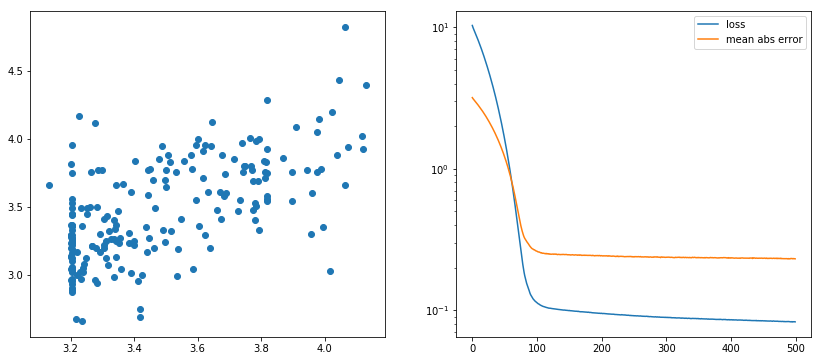

In [168]:
## sigmoid activation function
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid'))
    model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.12521327482265177 Mean Absolute Error: 0.2629388495556359 R-squared: 0.2891363920504161
mean squared error: 0.16079050476111253 Mean Absolute Error: 0.295500052640739 R-squared: 0.1911243089415361
mean squared error: 0.12472687945133303 Mean Absolute Error: 0.25498112527335565 R-squared: 0.21187778755475606


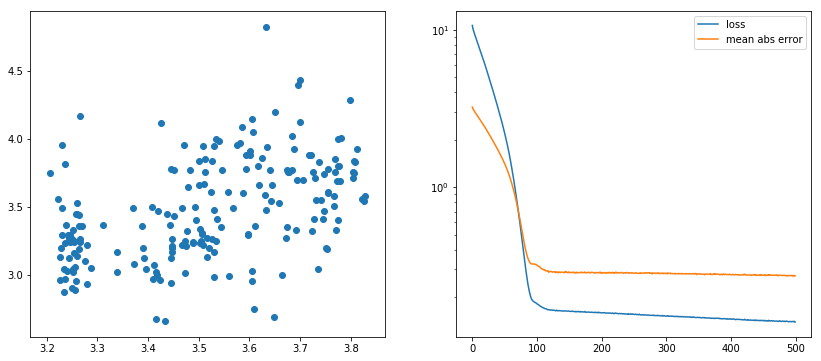

In [169]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)

for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

mean squared error: 0.11129703061673248 Mean Absolute Error: 0.24375827046273982 R-squared: 0.41377049047306236
mean squared error: 0.1233838612159479 Mean Absolute Error: 0.2559697740864985 R-squared: 0.40600867227243653
mean squared error: 0.10777367149911275 Mean Absolute Error: 0.23034830442289025 R-squared: 0.37323177652155715


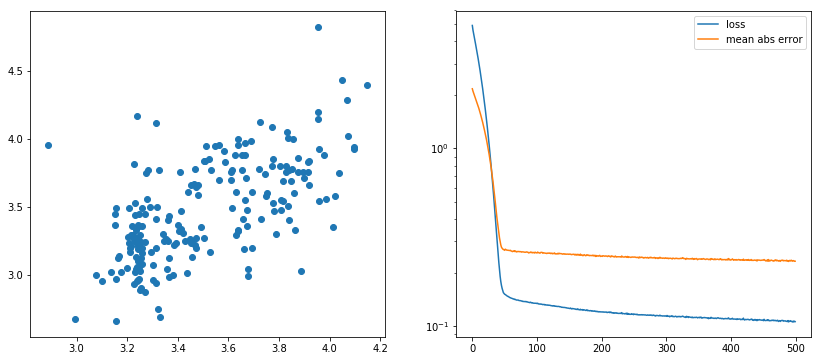

In [170]:
## sigmoid activation function with L1 regularization
w_reg = kr.l1(0.001)

#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]

    model = Sequential()
    model.add(Dense(5, input_dim=100, activation='sigmoid', kernel_regularizer = w_reg))
    model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
    model.add(Dense(1))

    # compile and fit
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    history= (model.fit(X_train_n, y_train, epochs=500, batch_size=50, verbose =0))
    # predict
    y_predict = model.predict(X_test_n)
    # evaluate
    mse_value, mae_value = model.evaluate(X_test_n, y_test, verbose = 0)
    r2 = r2_score(y_test,y_predict.flatten().tolist())
    print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

    

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()
ax[1].set_yscale('log')

## Linear regression + lasso regularisation

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 6.351984264886476e-05 
R2: 0.5274677325529235


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 5.316250368898416e-05 
R2: 0.47231790517443817
chosen alpha: 4.450324269125678e-05 
R2: 0.31373936718292783
r2: 0.31373936718292783


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


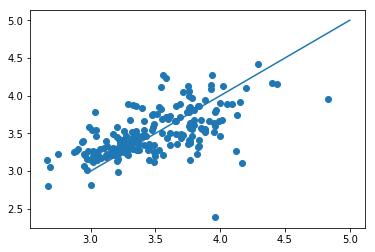

In [172]:
from sklearn.linear_model import LassoCV
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model= LassoCV(cv=20)
    model.fit(X_train_n, y_train)
    y_predict = model.predict(X_test_n)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.00030211003034018356 
R2: 0.5291877482201829


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha: 0.00027303274525066336 
R2: 0.4721255156570586
chosen alpha: 0.0001878567642492663 
R2: 0.3143339946186051
r2: 0.3143339946186051


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


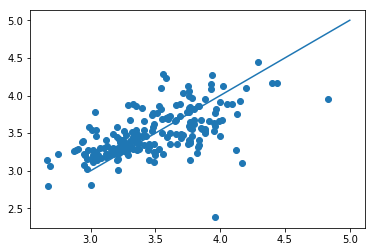

In [173]:
from sklearn.linear_model import LassoCV
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
    
    model= LassoCV(cv=20)
    model.fit(X_train_n, y_train)
    y_predict = model.predict(X_test_n)
    print("chosen alpha:", model.alpha_, '\nR2:', r2_score(y_test,y_predict))

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))

### Support vector regression

Max r2: 0.5645013856723403 
Epsilon: 0.045454545454545456
Max r2: 0.4622862905661218 
Epsilon: 0.03125
Max r2: 0.39071362446851987 
Epsilon: 0.016129032258064516


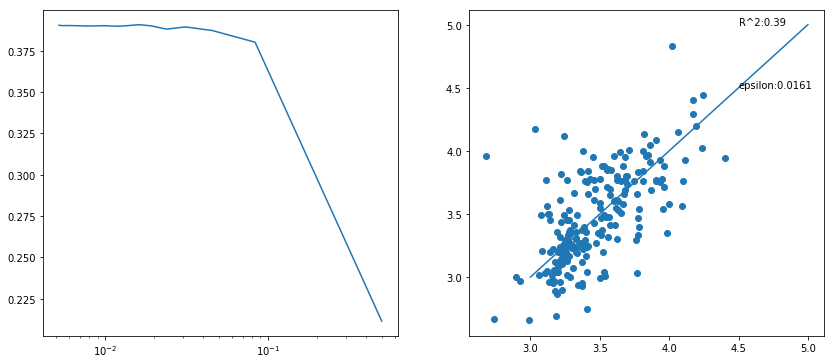

In [174]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 85, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.5505288828271542 
C: 100.0
Max r2: 0.4540684902031291 
C: 100.0
Max r2: 0.38155636330297726 
C: 16.666666666666668


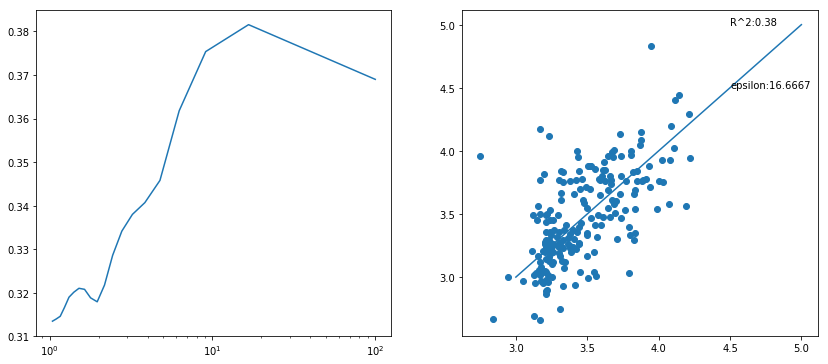

In [175]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR

for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 100/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.1, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.5659326626235859 
Epsilon: 0.045454545454545456
Max r2: 0.46638207638143275 
Epsilon: 0.045454545454545456
Max r2: 0.39633063774919197 
Epsilon: 0.00980392156862745


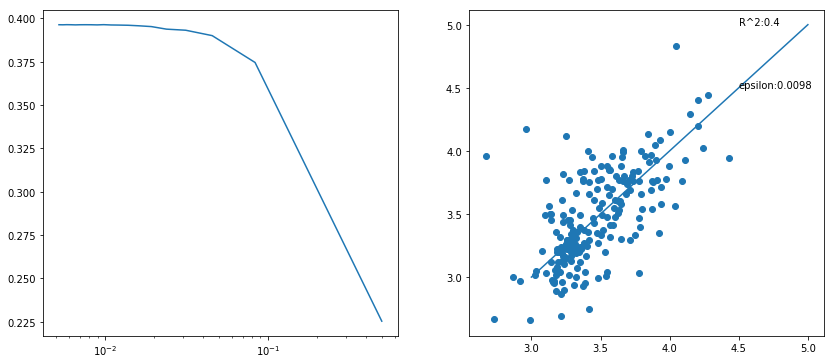

In [178]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 0.5/i
        ep.append(new_ep)
        clf = SVR(C= 5, epsilon = new_ep, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nEpsilon:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.5648658433621088 
C: 3.3333333333333335
Max r2: 0.46358735567507425 
C: 3.3333333333333335
Max r2: 0.39029930523716516 
C: 1.8181818181818181


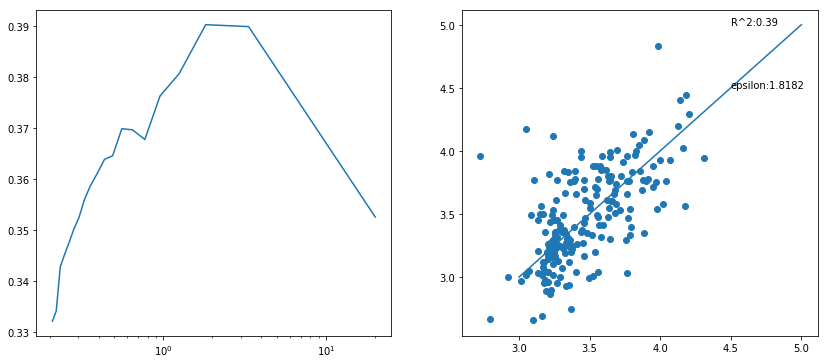

In [177]:
# varying C instead of epsilon # optimal C around 50 - 100
from sklearn.svm import SVR

#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
    
    svr_prediction = []
    svr_r2 = []
    ep =[]

    for i in range(1,100, 5):
        new_ep = 20/i
        ep.append(new_ep)
        clf = SVR(C= new_ep, epsilon = 0.05, kernel = 'linear')
        clf.fit(X_train_n, y_train)
        svr_prediction.append(clf.predict(X_test_n))
        svr_r2.append(clf.score(X_test_n,y_test))
    print('Max r2:', max(svr_r2), '\nC:', ep[svr_r2.index(max(svr_r2))])

    
fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(max(svr_r2),2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

Max r2: 0.4563592975631907 
C: 4
Max r2: 0.48471340143159464 
C: 8
Max r2: 0.36551033064348704 
C: 3


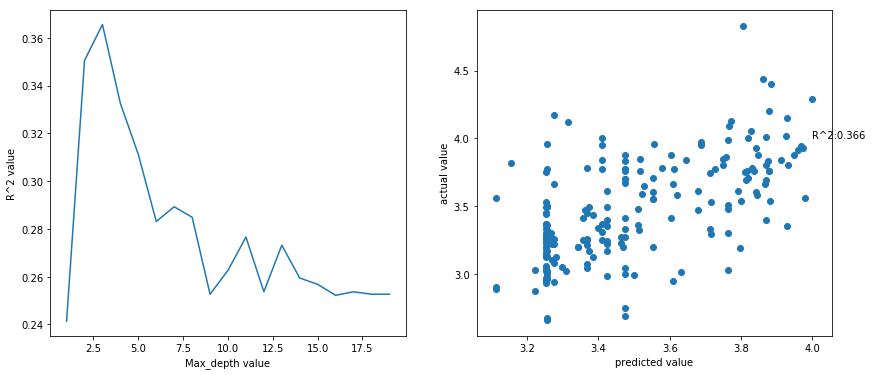

In [179]:
from sklearn.ensemble import RandomForestRegressor
    
    
for train_index, test_index in kf.split(X_norm):
#for train_index, test_index in kf.split(X_std):
    # split
    X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    #X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train_n, y_train)
        predictions.append(np.array(rf.predict(X_test_n)))
        rf_scores.append(rf.score(X_test_n, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')

Max r2: 0.4581713542623266 
C: 7
Max r2: 0.4828069904043754 
C: 8
Max r2: 0.3655444893768677 
C: 3


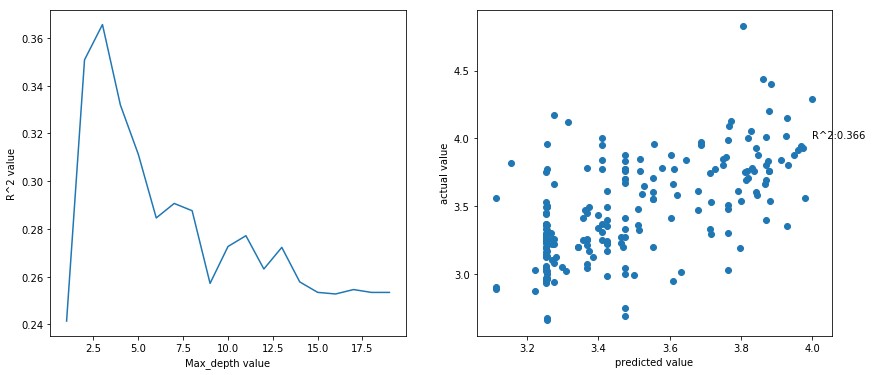

In [180]:
from sklearn.ensemble import RandomForestRegressor
    
    
#for train_index, test_index in kf.split(X_norm):
for train_index, test_index in kf.split(X_std):
    # split
    #X_train_n, X_test_n = X_norm.iloc[train_index,:], X_norm.iloc[test_index,:]
    X_train_n, X_test_n = X_std.iloc[train_index,:], X_std.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index,-1],Y.iloc[test_index,-1]
        
        
    
    rf_scores = []
    predictions=[]
    depth_list = []
    # need to try different max_depth:
    for depth in range(1, 20):
        depth_list.append(depth)
        rf = RandomForestRegressor(max_depth = depth, random_state=0)
        rf.fit(X_train_n, y_train)
        predictions.append(np.array(rf.predict(X_test_n)))
        rf_scores.append(rf.score(X_test_n, np.array(y_test)))
    print('Max r2:', max(rf_scores), '\nC:', depth_list[rf_scores.index(max(rf_scores))])
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(4,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')